# Recognizing hand-written digits - SGD from scratch
> Classify digits from MNIST dataset using a Stochastic Gradient Descent

- categories: [programming, fastai]
- comments: true
- toc: true

Inspired by [chapter 4](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb) in [The fastai book](https://github.com/fastai/fastbook). Check it out for more detailed description of the steps.

The book discusses problem of classifying 3s and 7s. Here, I tackle the same classification, but with all ten digits.

## Objective
Design a model that can classify hand-written digits from MNIST dataset.

## Steps

### Download, sort, show

In [2]:
#hide
from fastai.vision.all import *
from utils import *
from fastbook import *

from math import inf

matplotlib.rc('image', cmap='Greys')

Download the dataset.

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
# hide
Path.BASE_PATH = path

In [5]:
(path/'training').ls()

(#10) [Path('training/0'),Path('training/2'),Path('training/9'),Path('training/8'),Path('training/7'),Path('training/1'),Path('training/5'),Path('training/4'),Path('training/6'),Path('training/3')]

Store the image paths to a nested list.
We can access the images for every digit by indexing the container. Since the python indexing starts from 0, the indexes conveniently follow the underlying digits.

In [6]:
digits = []
for i in range(10):
    current_digit_path = (path/'training'/str(i))
    current_digit = current_digit_path.ls().sorted()
    digits.append(current_digit)

In [7]:
twos = digits[2]
im2_path = twos[1]
im2 = Image.open(im2_path)
im2 

The images are represented by pixels, each of which holds the value from 0 (black) to 255 (white), with gradients of grey between. For example, 20 would be *almost* black.

We can see the underlying representation of images by converting them to NumPy array...

In [8]:
array(im2)[2:7,6:12]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  81, 131, 152],
       [  0,   0,  14, 209, 253, 242],
       [  0,   0,  25, 228,  95,   0],
       [  0,   0,  11,  41,   0,   0]], dtype=uint8)

...or by creating a Pandas dataframe from tensor, and then plotting the grey-scale using the pixel values.

In [9]:
im2_t = tensor(im2)
df = pd.DataFrame(im2_t[2:15,6:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,81,131,152,194,194,225,98,5,0,0,0
2,0,0,14,209,253,242,242,242,251,254,183,9,0,0
3,0,0,25,228,95,0,0,0,113,250,254,219,24,0
4,0,0,11,41,0,0,0,0,0,80,210,254,167,22
5,0,0,0,0,0,0,0,0,0,0,75,254,254,113
6,0,0,0,0,0,0,0,0,0,0,28,223,254,161
7,0,0,0,0,0,0,0,0,0,0,0,124,254,223
8,0,0,0,0,0,0,0,0,0,0,0,82,254,254
9,0,0,0,0,0,0,0,0,0,0,0,82,254,254


### Measuring the difference: Pixel similarity

One straight-forward way to categorize the images would be to measure pixel similarity.

That is, for every digit, we take all of the images from the training set, and for each pixel we calculate the average value.

To classify new number, we compare each pixel of this new number with the corresponding "average" pixel of a digit. We classify it as a digit where the difference was smallest.

#### Creating "average" digits

First, we convert the digit images to tensors.

In [10]:
digit_tensors = []
for d_images in digits:
    digit_tensors.append([tensor(Image.open(o)) for o in d_images])

In [11]:
for d_tensors in digit_tensors:
    print(len(d_tensors), end=", ")

5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949, 

To calculate the average pixel values of a digit, we need to stack all of the corresponding digits to a single three-dimensional tensor - *rank-3 tensor*. 

In [12]:
stacked_digit_tensors = []
for t in digit_tensors:
    stacked_current = torch.stack(t).float()/255
    stacked_digit_tensors.append(stacked_current)

And calculate the mean.

In [13]:
digit_means = []
for s_d in stacked_digit_tensors:
    digit_means.append(s_d.mean(0))

We can see how an "ideal" 2 looks like.

<AxesSubplot:>

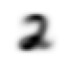

In [14]:
show_image(digit_means[2])

And the whole range.

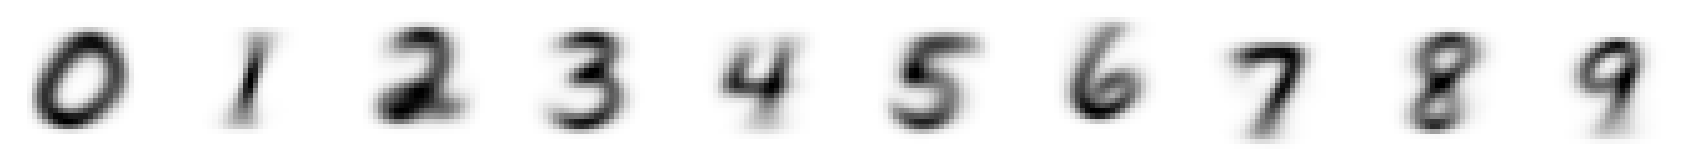

In [15]:
show_images(digit_means)

To recap, this digits are just average values of every pixel for a given digit.

#### Measuring the similarity

There are two main ways to measure the similarity of the images:
1. Mean of the **absolute value of differences** - *mean absolute difference* - *L1 norm*
2. Mean of the **square of differences** - *root mean squared error* - *L2 norm*

The main difference is that the latter penalizes bigger differences more.

We're going to use both techniques.
We start by picking a random two digit. Then, compare it to an ideal 2 and ideal 4.

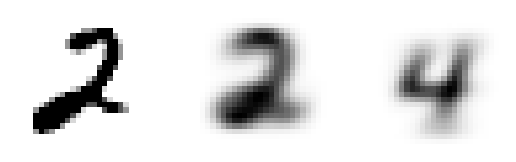

In [16]:
a_2 = stacked_digit_tensors[2][0]
mean_2 = digit_means[2]
mean_4 = digit_means[4]
show_images([a_2, mean_2, mean_4])

L1-norm with our random 2:

In [17]:
dist_2_abs = (a_2 - mean_2).abs().mean()
dist_2_abs

tensor(0.1350)

`a_2 - mean_2` returns a tensor - differences for every pixel.
Then, mean is calculated from absolute values of the differences.

<AxesSubplot:>

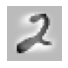

In [18]:
show_image(a_2 - mean_2)

L2-norm:

In [19]:
dist_2_sqr = ((a_2 - mean_2)**2).mean()
dist_2_sqr

tensor(0.0547)

Now, compare the random 2 to ideal 4.

In [20]:
dist_4_abs = (a_2 - mean_4).abs().mean()
dist_4_sqr = ((a_2 - mean_4)**2).mean()
dist_4_abs, dist_4_sqr

(tensor(0.1750), tensor(0.1036))

In both cases, the distance to the mean-4 is greater than the distance to the mean 2 - so the model would pick the right number.

PyTorch comes with both of these loss functions in `torch.nn.functional` as `l1_loss` and `mse_loss`.

In [21]:
F.l1_loss(a_2.float(),mean_2), F.mse_loss(a_2,mean_2).sqrt()

(tensor(0.1350), tensor(0.2338))

### Calculating accuracy

Now, we would like to see how good the predictions actually are. We can find out by using digits from validation set and comparing the predictions to actual values.

In [22]:
validation_digits = []
for i in range(10):
    valid_current = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'testing'/str(i)).ls()])
    valid_current = valid_current.float()/255
    validation_digits.append(valid_current)

In [23]:
validation_digits[3].shape

torch.Size([1010, 28, 28])

A function to calculate distance between two tensors. It utilizes *broadcasting* - automatically expanding smaller rank tensor if the ranks of tensor arguments don't match.

In [24]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))

Same rank:

In [25]:
mnist_distance(a_2, mean_2)

tensor(0.1350)

Non-matching rank:

In [26]:
mnist_distance(validation_digits[2], mean_2)

tensor([0.1275, 0.1369, 0.1477,  ..., 0.1503, 0.1582, 0.1609])

Note that this doesn't actually *create* new copies of `mean_2` - it just behaves like it did.

We'll use this `mnist_distance` to classify images. We guess the image to represent number where it had smallest distance from the mean image.

In [27]:
def is_target(tns, target):
    target_mean = digit_means[target]
    other_means = digit_means[:target] + digit_means[target+1:]
    intermed_tns = tensor([True])
    for o_mean in other_means:
        target_dist = mnist_distance(tns, target_mean) 
        o_dist = mnist_distance(tns, o_mean)
        x = target_dist < o_dist
        intermed_tns = torch.logical_and(intermed_tns, x)
        
    return intermed_tns

In [28]:
acc_sum = 0
for i in range(10):
    accuracy = is_target(stacked_digit_tensors[i], i).float().mean()
    print(f"{i}: {accuracy*100:.2f}%")
    acc_sum += float(accuracy)
    
print(f"Mean accuracy: {acc_sum/10*100:.2f}%")

0: 81.41%
1: 99.81%
2: 43.29%
3: 58.36%
4: 66.48%
5: 30.01%
6: 74.54%
7: 77.78%
8: 39.58%
9: 71.63%
Mean accuracy: 64.29%


As you can see, the predictions are all over the place, but the result is not bad - more than 6 times better than random guesses.
*Note: Extremely high accuracy with predicting 1s is a little unsettling and looks like a bug - if it is, I wasn't able to locate it.*

### Stochastic Gradient Descent

SGD: Find local minima of a loss function by changing the parameters. Adjust the rate at which each parameter changes by calculating gradients (steepness of the slope).

**Steps**
1. Initialize weights randomly
1. Calculate the predictions 
1. Calculate the loss
1. Calculate the gradients
1. Step the weights
1. Repeat
1. End

Before we begin, we create a dataset that contains `digit tensor, label` pairs.

In [29]:
train_x = torch.cat(stacked_digit_tensors).view(-1, 28*28)
labels = []
for i in range(10):
    labels += [i] * len(digits[i])
train_y = tensor(labels).unsqueeze(-1)
train_x.shape, train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

In [30]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

Same for validation set:

In [31]:
valid_x = torch.cat([t for t in validation_digits]).view(-1, 28*28)
labels = []
for i in range(10):
    labels += [i] * len(validation_digits[i])
valid_y = tensor(labels).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

**Step 1: Initialize the parameters randomly**

In [32]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

We want the weights to output in 10 dimensions - 1 for each digit.

In [33]:
weights = init_params((28*28, 10))

If all the pixels would be 0, no matter the weights, the function would return zero. To avoid this, we include *bias* - that is the *b* in w*x+b.

In [34]:
bias = init_params(10)

#### Step 2: Calculate the predictions

We can calculate the prediction now.
We'll use *matrix multiplication* to calculate w\*x for every row in a matrix.

In [56]:
def linear1(xb): return (xb@weights + bias)
preds = linear1(train_x)
preds[0], preds.shape

(tensor([-11.9867,  -4.2706,   4.6806,   8.3393,   2.6384,   8.4428,  -5.3335,  -1.3517,  -0.0395,  13.5840], grad_fn=<SelectBackward>),
 torch.Size([60000, 10]))

#### Step 3: Calculate the loss

We can calculate the accuracy of our model now.

In [57]:
def p_to_digit(x):
    return x.argmax(-1)

def accuracy(xb, yb):
    return (p_to_digit(xb) == yb).float().mean()

To do that, we need to convert the prediction tensor to a digit by picking up a digit with highest confidence.

Then we just compare if the predicted digit is equal to the label.

To test this, pick two numbers with labels and calculate their predictions.

In [58]:
two_numbers = tensor(train_x[10000:10002])
two_labels = tensor(train_y[10000:10002])
two_preds = linear1(two_numbers)

In [59]:
two_preds[0]

tensor([ 1.0390,  3.3584, -4.7083, -6.4347, -7.8454, -1.6740,  5.4817, -4.1297, 16.2386, 13.1670], grad_fn=<SelectBackward>)

In [60]:
p_to_digit(two_preds), two_labels

(tensor([8, 8]),
 tensor([[1],
         [1]]))

In [61]:
accuracy(two_preds, two_labels)

tensor(0.)

We get around ~10% accuracy, as would expect.
We want to use gradients to improve our model using SGD. We could use accuracy as our *loss function*.
But there's a problem. Gradients are calculated over the slope of the function  (*rise over run*). Now, some changes to the parameters might not be enough to change the prediction to different number.

We need a loss function that changes *everytime* we tweak the parameters.

We can do this by predicting not only the digit, but also the *confidence* of the prediction.
We use [softmax](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.softmax) to keep the predictions in [0,1] interval proportional to the original values.

Before writing the loss function, we need to come up with a way to convert labels to tensor expressing *confidences* for every digit. That is, it should have a value **1** for the target digit, and **0** for every other digit. The loss will use this tensor to calculate the distance from the desired answer.

In [62]:
def label_to_tensor(l):
    l = l.type(torch.int64)
    return (torch.zeros(l.shape[0], 10)).scatter_(1, l, 1)

In [63]:
def mnist_loss(predictions, targets):
    predictions = predictions.softmax(-1)
    targets = label_to_tensor(targets)
    return (predictions - targets).abs().mean()

#### Step 4: Calculate the gradients

Calculating the loss one item at a time would be too slow, but doing it all at once would take a long time. We settle for a compromise: *mini-batches* - calculation are taken on a batch of items at a time.
This also utilizes GPUs capabilities to perform tasks in pararel. 

In [64]:
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

weights = init_params((28*28,10))
bias = init_params(10)

In [65]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

* **Training**

    * When training, we step in the opposite direction of the gradient to move to the function minima.
    * Don't forget to zero out the gradients to avoid them being added together after multiple runs.
    * *Learning rate* is used to adjust the size of the steps - to augment the gradients impact.

In [66]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [67]:
def validate_epoch(model):
    accs = [accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [68]:
validate_epoch(linear1)

0.1019

With random weights, the ~10% shouldn't surprise us.
But does it actually get better if we *train* the model?

In [69]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.179

It does! 

We can train some more.

In [70]:
lr = 1.
params = weights,bias
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.2245 0.2615 0.2982 0.3306 0.3526 0.3692 0.3823 0.3964 0.4115 0.4234 0.4365 0.4467 0.455 0.4641 0.471 0.4791 0.4859 0.4942 0.5069 0.5257 

The accuracy after a few training cycles reaches ~50%, which is quite good, for such a simple model!

Altough the pixel similarity model worked better, this is a basic block which we can build on. And it's actually *learning*.

### Creating an Optimizer

Unsurprisingly, there's bunch of PyTorch classes that make this easier to implement. 
*nn.Linear* is a combination of our *init_params* and *linear1*.

In [71]:
linear_model = nn.Linear(28*28,10)
linear_model

Linear(in_features=784, out_features=10, bias=True)

A purpose of the *optimizer* is to minimalize the loss function by stepping the weights, as we've done in *calc_grad* and *train_epoch*.

*fastai* provides *SGD*, which does essentialy the same as we did.

We can use *Learner* to put it all together.

In [72]:
dls = DataLoaders(dl, valid_dl)

In [73]:
learn = Learner(dls, nn.Linear(28*28,10), opt_func=SGD,
                loss_func=mnist_loss, metrics=accuracy)

In [74]:
learn.fit(20, lr=1.)

epoch,train_loss,valid_loss,accuracy,time
0,0.177227,0.160779,0.193971,00:01
1,0.103887,0.155185,0.221862,00:01
2,0.069117,0.139903,0.309807,00:00
3,0.059987,0.128441,0.360148,00:00
4,0.054112,0.118848,0.401384,00:00
5,0.051850,0.110999,0.440786,00:00
6,0.050422,0.105058,0.467323,00:00
7,0.049435,0.100271,0.487337,00:01
8,0.048716,0.096281,0.502976,00:01
9,0.048168,0.092869,0.518368,00:00


This performs slightly better than our model. My guess would be that *SGD* optimizer is slightly more advanced than ours. I'll update this when I find out.

We can advance to crucial step - adding more layers.

### More layers and nonlinearity

If we added only another (linear) layer, those two layers could be modified (by using calculus) to be represented as a single linear function.
The solution is to add a **nonlinear** function between the two. 

Now, it's not possible to simplify it to single linear function.

In [75]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30), # linear layer
    nn.ReLU(), # nonlinearity
    nn.Linear(30,10) # linear layer
)

*nn.ReLU* is essentialy *max(0, x)*. It turns any negative numbers to zero, leaving positive numbers untouched.

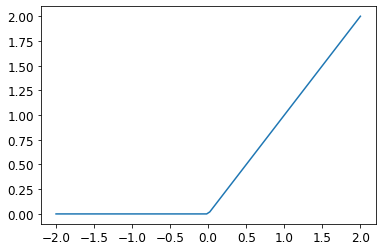

In [76]:
plot_function(F.relu)

In [77]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=accuracy)

In [78]:
learn.fit(20,0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.181457,0.178528,0.217043,00:01
1,0.180678,0.175846,0.250777,00:01
2,0.180115,0.169476,0.265250,00:01
3,0.178958,0.155737,0.298626,00:01
4,0.174436,0.142253,0.325580,00:01
5,0.169929,0.132780,0.346405,00:01
6,0.165284,0.125421,0.414369,00:01
7,0.159455,0.121954,0.414507,00:01
8,0.152856,0.117419,0.415911,00:01
9,0.148755,0.110323,0.435318,00:01


The results are slightly disappointing - the accuracy after 20 cycles is similar to our single-layer model.
What happens if we add another layer?

In [79]:
bigger_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30, 30),
    nn.ReLU(),
    nn.Linear(30, 10),
)

In [80]:
b_learn = Learner(dls, bigger_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=accuracy)

In [81]:
b_learn.fit(20, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.180283,0.179822,0.102665,00:01
1,0.180089,0.179545,0.153138,00:01
2,0.179895,0.179211,0.156936,00:01
3,0.179665,0.178729,0.203679,00:01
4,0.179366,0.178033,0.228775,00:01
5,0.179014,0.176945,0.250143,00:01
6,0.178602,0.175029,0.289143,00:01
7,0.177946,0.171027,0.352468,00:01
8,0.176338,0.164895,0.396136,00:01
9,0.173490,0.157322,0.405480,00:01


The model got even worse!

*What is going on here?*
Frankly, I don't know. Perhaps I should pick other *learning rate*? Or my loss function is off. Maybe I'm missing something wholly different.

But glance at the internet reveals there might be other problems: 
* *overfitting* caused by more layers
* problem with *initializing the weights*
* problem with gradients (e.g. *vanishing gradient*)

Since I'm still only at the beginning of my ML journey, I can't easily solve the problem. I hope to update this blog when I'll find out what's the deal here.

### Final remarks

In this blog, we've gone through comparing images by pixel similarity to working neural network learning through SGD. Even if the results were a bit disappointing, it was clear that the model *learned* and gradually improved the performance - even with starting out with completely random values!

I was surprised by the simplicity of the SGD. You pick a random weights and the nudge them into the right direction to minimize the loss function, and you can adjust the "nudge" by how steep the change is. So cool!